### 循环神经网络模型模型：Encoder-Decoder with LSTM cell

新思路：将样本ID经过embedding之后，作为init_state输入到RNN中

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/es_with_decay.array'
transplant_arr_path = r'../output/transplant/es_with_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 10)
Shape of the transplant array: (5141, 17, 10)


Document frequency: [0. 0. 0. 0. 0. 1. 2. 0. 1. 3. 2. 2. 0. 0. 2. 0. 0.]
Emerging score: [0.         0.         0.         0.         0.         0.69314718
 2.04146483 0.42790259 1.46994593 3.89584482 1.59730596 2.26917525
 0.72507928 0.65257135 2.2323199  0.71293627 0.64164265]
Total DF: 13.0


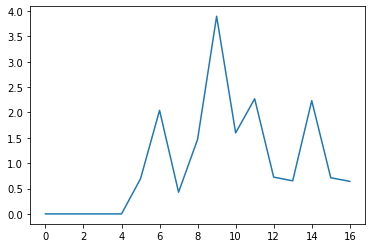

In [3]:
i = 34
print('Document frequency:', transplant_arr[i, :, 0])
print('Emerging score:', transplant_arr[i, :, -2])
print('Total DF:', np.sum(transplant_arr[i, :, 0]))
plt.plot(transplant_arr[i, :, -2])
plt.show()

### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [4]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 10)
Shape of the transplant array: (5141, 16, 10)


### 规范数据并获取训练集和测试集

In [5]:
scaler, data = scale_data(transplant_arr, 'standard')
# X_train, X_test, y_train, y_test = split_data(data, 11, 0.2)
X_train, X_test, y_train, y_test = split_data_by_time(data, 6, 5, False)
# _, _, _, y_test_origin = split_data_by_time(transplant_arr, 6, 5, False)
print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (5141, 6, 10)
X_test.shape: (5141, 6, 10)
y_train.shape: (5141, 5)
y_test.shape: (5141, 5)


### 构建模型

In [6]:
def build_direct_model(lstm_units, dense_units):
    model = keras.models.Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(y_train.shape[1]))
    
    model.compile(loss='mae', optimizer='rmsprop')
    return model

In [7]:
def build_encoder_decoder_model(lstm_units, dense_units):
    model = keras.models.Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(RepeatVector(y_train.shape[1]))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(dense_units, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    model.compile(loss='mae', optimizer='rmsprop')
    return model

In [8]:
def build_tf_encoder_decoder_model(input_dims, output_dims, lstm_units):
    # 训练模式
    # encoder，获取其隐藏状态，丢弃其输出
    enc_inputs = Input(shape=(None, input_dims))
    enc = LSTM(lstm_units, return_state=True, dropout=0.2)
    enc_outputs, state_h, state_c = enc(enc_inputs)
    enc_states = [state_h, state_c]
    
    # decoder，输入encoder的隐藏状态和目标序列的往后平移1位的输入，以一个开始标记开始
    dec_inputs = Input(shape=(None, output_dims))
    dec = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.2)
    dec_outputs, _, _ = dec(dec_inputs, initial_state=enc_states)
    
    # dense输出
    dec_dense = Dense(output_dims, activation=None)
    dec_outputs = dec_dense(dec_outputs)
    
    model = Model([enc_inputs, dec_inputs], dec_outputs)
    
    # 推断模式，重用了上面的层，下面的模型只需要predict而不需要train
    # encoder很简单，一样的
    enc_model = Model(enc_inputs, enc_states)
    
    # decoder和前面不同的是需要接收自己的隐藏状态（第一次为encoder的隐藏状态），
    # 这里的shape为什么是这样？
    dec_state_input_h = Input(shape=(lstm_units,))
    dec_state_input_c = Input(shape=(lstm_units,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec(dec_inputs, initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    
    dec_model = Model([dec_inputs] + dec_states_inputs,
                     [dec_outputs] + dec_states)
    
    model.compile(optimizer='rmsprop', loss='mae')
    
    return model, enc_model, dec_model

def predict_seq(enc_model, dec_model, input_seq, pred_steps):
    # 先encode序列，获得encoder的隐藏状态
    enc_states = enc_model.predict(input_seq)
    
    # 生成一个形状为(samples, timesteps, output_dims)的占位序列，该序列由开始标记开始
    # 这里我们一步步进行
    # 开始标记的选择也是个问题，暂时用0.0
    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = 0.0
    
    output_seq = []
    for _ in range(pred_steps):
        single_out, h, c = dec_model.predict([target_seq] + enc_states)
        
        output_seq.append(single_out[0, 0, 0])
        
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = single_out[0, 0, 0]
        
        enc_states = [h, c]
    
    return output_seq

In [9]:
def build_tf_id_encoder_decoder_model(input_dims, output_dims, id_dims, lstm_units):
    # 训练模式
    # ID接入
    id_inputs = Input(shape=(id_dims,))
#     id_dense = Dense(512, activation='relu')(id_inputs)
    id_dense = Dense(lstm_units, activation='relu')
    id_outputs = id_dense(id_inputs)
    id_outputs = Dropout(0.4)(id_outputs)
    id_states = [id_outputs, id_outputs]
    
    # encoder，获取其隐藏状态，丢弃其输出
    enc_inputs = Input(shape=(None, input_dims))
    enc = LSTM(lstm_units, return_state=True)
    enc_outputs, state_h, state_c = enc(enc_inputs, initial_state=id_states)
    enc_states = [state_h, state_c]
    
    # decoder，输入encoder的隐藏状态和目标序列的往后平移1位的输入，以一个开始标记开始
    dec_inputs = Input(shape=(None, output_dims))
    dec = LSTM(lstm_units, return_sequences=True, return_state=True)
    dec_outputs, _, _ = dec(dec_inputs, initial_state=enc_states)
    
    # dense输出
    dec_dense = Dense(output_dims, activation=None)
    dec_outputs = dec_dense(dec_outputs)
    
    model = Model([enc_inputs, dec_inputs, id_inputs], dec_outputs)
    
    # 推断模式，重用了上面的层，下面的模型只需要predict而不需要train
    # encoder很简单，一样的
    enc_model = Model([enc_inputs, id_inputs], enc_states)
    
    # decoder和前面不同的是需要接收自己的隐藏状态（第一次为encoder的隐藏状态），
    # 这里的shape为什么是这样？
    dec_state_input_h = Input(shape=(lstm_units,))
    dec_state_input_c = Input(shape=(lstm_units,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec(dec_inputs, initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    
    dec_model = Model([dec_inputs] + dec_states_inputs,
                     [dec_outputs] + dec_states)
    
    model.compile(optimizer='rmsprop', loss='mae')
    
    return model, enc_model, dec_model

def predict_seq_with_id(enc_model, dec_model, input_seq, ids, pred_steps):
    # 先encode序列，获得encoder的隐藏状态
    enc_states = enc_model.predict([input_seq.copy(), ids.copy()])
    
    # 生成一个形状为(samples, timesteps, output_dims)的占位序列，该序列由开始标记开始
    # 这里我们一步步进行
    # 开始标记的选择也是个问题，暂时用0.0
    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = 0.0
    
    output_seq = []
    for _ in range(pred_steps):
        single_out, h, c = dec_model.predict([target_seq] + enc_states)
        
        output_seq.append(single_out[0, 0, 0])
        
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = single_out[0, 0, 0]
        
        enc_states = [h, c]
    
    return output_seq

训练

In [10]:
decoder_in_training = np.roll(y_train, 1, axis=1)
decoder_in_training[:, 0] = 0.0
decoder_in_training = decoder_in_training.reshape(len(decoder_in_training), -1, 1)

decoder_in_validation = np.roll(y_test, 1, axis=1)
decoder_in_validation[:, 0] = 0.0
decoder_in_validation = decoder_in_validation.reshape(len(decoder_in_validation), -1, 1)

ids = np.arange(len(X_train)).reshape(-1, 1)
enc = OneHotEncoder(categories='auto')
ids = enc.fit_transform(ids).toarray()

In [10]:
model = build_direct_model(256, 256)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[])

Train on 5141 samples, validate on 5141 samples
Epoch 1/20
5141/5141 [==============================] - 13s 3ms/sample - loss: 0.3216 - val_loss: 0.2437
Epoch 2/20
5141/5141 [==============================] - 7s 1ms/sample - loss: 0.3001 - val_loss: 0.2612
Epoch 3/20
5141/5141 [==============================] - 7s 1ms/sample - loss: 0.2969 - val_loss: 0.2804
Epoch 4/20
5141/5141 [==============================] - 7s 1ms/sample - loss: 0.2950 - val_loss: 0.2564
Epoch 5/20
5141/5141 [==============================] - 7s 1ms/sample - loss: 0.2942 - val_loss: 0.2542
Epoch 6/20
5141/5141 [==============================] - 7s 1ms/sample - loss: 0.2926 - val_loss: 0.2587
Epoch 7/20
5141/5141 [==============================] - 7s 1ms/sample - loss: 0.2922 - val_loss: 0.2480
Epoch 8/20
5141/5141 [==============================] - 8s 2ms/sample - loss: 0.2907 - val_loss: 0.2462
Epoch 9/20
5141/5141 [==============================] - 7s 1ms/sample - loss: 0.2894 - val_loss: 0.2653
Epoch 10/20
514

In [8]:
model = build_encoder_decoder_model(256, 256)
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=[])

Train on 5141 samples, validate on 5141 samples
Epoch 1/20
5141/5141 [==============================] - 37s 7ms/sample - loss: 0.4504 - val_loss: 0.4496
Epoch 2/20
5141/5141 [==============================] - 26s 5ms/sample - loss: 0.4234 - val_loss: 0.4574
Epoch 3/20
5141/5141 [==============================] - 26s 5ms/sample - loss: 0.4179 - val_loss: 0.4319
Epoch 4/20
5141/5141 [==============================] - 26s 5ms/sample - loss: 0.4140 - val_loss: 0.4281
Epoch 5/20
5141/5141 [==============================] - 25s 5ms/sample - loss: 0.4122 - val_loss: 0.4245
Epoch 6/20
5141/5141 [==============================] - 26s 5ms/sample - loss: 0.4102 - val_loss: 0.4340
Epoch 7/20
5141/5141 [==============================] - 26s 5ms/sample - loss: 0.4084 - val_loss: 0.4316
Epoch 8/20
5141/5141 [==============================] - 26s 5ms/sample - loss: 0.4070 - val_loss: 0.4741
Epoch 9/20
5141/5141 [==============================] - 26s 5ms/sample - loss: 0.4059 - val_loss: 0.4300
Epoch 1

In [64]:
model, encoder_model, decoder_model = build_tf_encoder_decoder_model(11, 1, 512)
history = model.fit([X_train, decoder_in_training], y_train, 
                    epochs=50, validation_data=([X_test, decoder_in_validation], y_test), batch_size=16,
                    callbacks=[])

Train on 5141 samples, validate on 5141 samples
Epoch 1/50
5141/5141 [==============================] - 33s 6ms/sample - loss: 0.4971 - val_loss: 0.4796
Epoch 2/50
5141/5141 [==============================] - 27s 5ms/sample - loss: 0.4833 - val_loss: 0.4677
Epoch 3/50
5141/5141 [==============================] - 27s 5ms/sample - loss: 0.4795 - val_loss: 0.4744
Epoch 4/50
5141/5141 [==============================] - 28s 5ms/sample - loss: 0.4760 - val_loss: 0.4663
Epoch 5/50
5141/5141 [==============================] - 27s 5ms/sample - loss: 0.4731 - val_loss: 0.4770
Epoch 6/50
5141/5141 [==============================] - 27s 5ms/sample - loss: 0.4714 - val_loss: 0.4667
Epoch 7/50
5141/5141 [==============================] - 27s 5ms/sample - loss: 0.4684 - val_loss: 0.4606
Epoch 8/50
5141/5141 [==============================] - 27s 5ms/sample - loss: 0.4670 - val_loss: 0.4645
Epoch 9/50
5141/5141 [==============================] - 27s 5ms/sample - loss: 0.4662 - val_loss: 0.4570
Epoch 1

In [13]:
X_train.shape, decoder_in_training.shape, ids.shape

((5141, 6, 10), (5141, 5, 1), (5141, 5141))

In [14]:
X_test.shape, decoder_in_validation.shape, ids.shape

((5141, 6, 10), (5141, 5, 1), (5141, 5141))

In [11]:
model, encoder_model, decoder_model = build_tf_id_encoder_decoder_model(10, 1, len(ids[0]), 512)
history = model.fit([X_train, decoder_in_training, ids], y_train, 
                    epochs=100, validation_data=([X_test, decoder_in_validation, ids], y_test), batch_size=128,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto', restore_best_weights=True)
                    ])

Train on 5141 samples, validate on 5141 samples
Epoch 1/100
1280/5141 [======>.......................] - ETA: 21s - loss: 0.5343WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

预测

from tensorflow.keras.models import load_model

model = load_model(r'C:\Users\Tom Leung\Desktop\best.h5')
y_pred = model.predict(X_test).reshape(y_test.shape)

In [9]:
train_pred = model.predict(X_train).reshape(y_train.shape)
y_pred = model.predict(X_test).reshape(y_test.shape)

In [65]:
# teacher forcing with ID
# y_pred = list()
# for i in range(X_test.shape[0]):
#     y_pred.append(predict_seq_with_id(encoder_model, decoder_model, X_test[i:i+1], ids[i:i+1], pred_steps=3))
# y_pred = np.array(y_pred)

# teacher forcing without ID
y_pred = list()
for i in range(X_test.shape[0]):
    y_pred.append(predict_seq(encoder_model, decoder_model, X_test[i:i+1], pred_steps=5))
y_pred = np.array(y_pred)

# no teacher forcing
# y_pred = model.predict(X_test)
# y_pred = y_pred.reshape(y_test.shape)

In [66]:
# teacher forcing with ID
# train_pred = list()
# for i in range(X_train.shape[0]):
#     train_pred.append(predict_seq_with_id(encoder_model, decoder_model, X_train[i:i+1], ids[i:i+1], pred_steps=3))
# train_pred = np.array(train_pred)

# teacher forcing without ID
train_pred = list()
for i in range(X_train.shape[0]):
    train_pred.append(predict_seq(encoder_model, decoder_model, X_train[i:i+1], pred_steps=5))
train_pred = np.array(train_pred)

# no teacher forcing
# train_pred = model.predict(X_train)
# train_pred = train_pred.reshape(y_train.shape)

[1628, 4464, 3436, 1805, 3679, 4827, 2278, 53, 1307, 3462]
[0.45706629 0.32932146 0.39823819 1.91237976 1.81987674 1.57811333
 1.89793463 0.94015915 0.75304219 1.10971949]


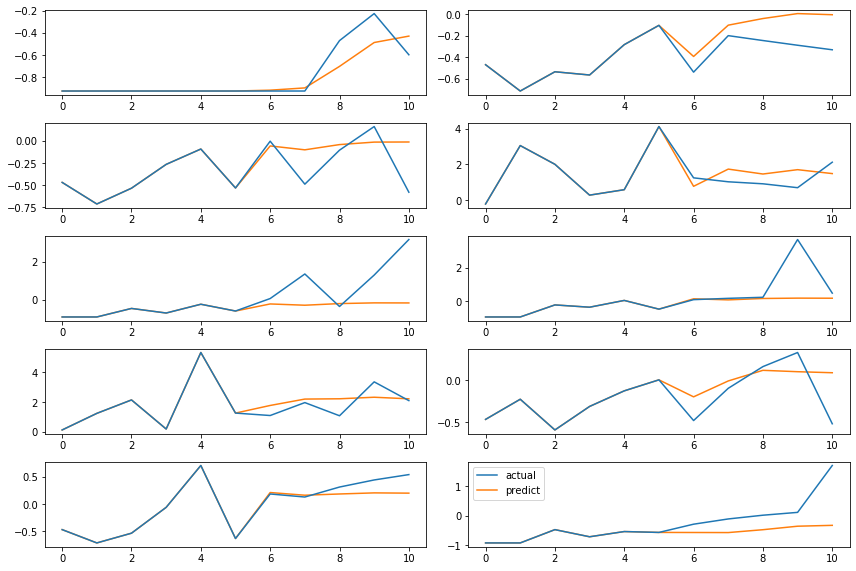

In [12]:
rand_ids = random.sample(range(len(y_train)), 10)
print(rand_ids)
print(np.std(transplant_arr[rand_ids, :, -2], axis=1))

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_train[rand_ids[i], :, -2], y_train[rand_ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_train[rand_ids[i], :, -2], train_pred[rand_ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

[1728, 4646, 2577, 1741, 4089, 3241, 3758, 1170, 2169, 1143]


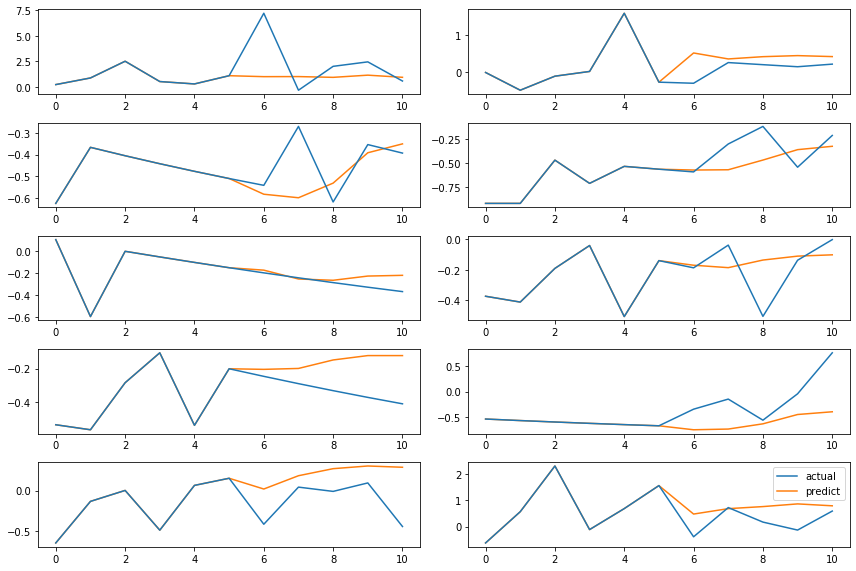

In [23]:
rand_ids = random.sample(range(len(y_test)), 10)
print(rand_ids)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_test[rand_ids[i], :, -2], y_test[rand_ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_test[rand_ids[i], :, -2], y_pred[rand_ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

[2401, 5066, 2962, 4729, 1575, 569, 375, 1866, 2370, 653]


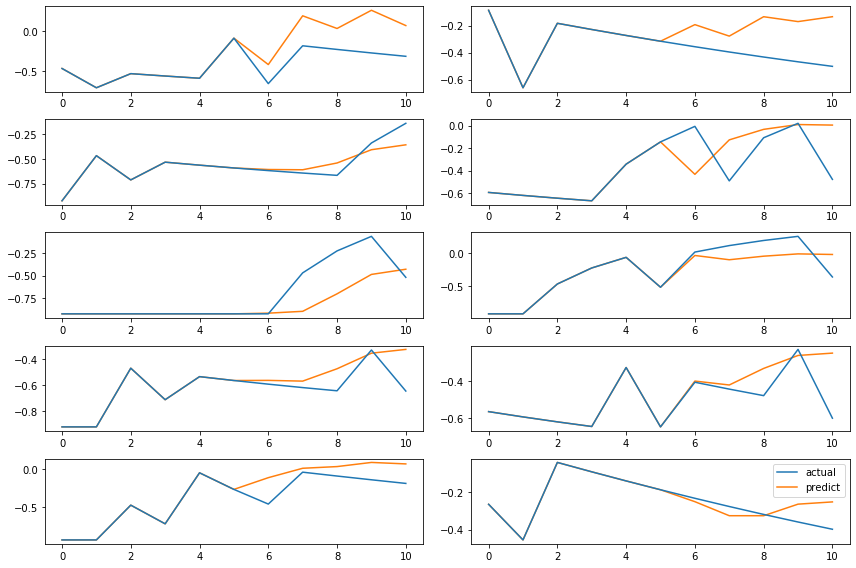

In [19]:
rand_ids = random.sample(range(len(y_test)), 10)
print(rand_ids)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    if i % 2 == 1:
        plt.plot(np.concatenate((X_test[rand_ids[i], :, -2], y_test[rand_ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
        plt.plot(np.concatenate((X_test[rand_ids[i], :, -2], y_pred[rand_ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
    else:
        plt.plot(np.concatenate((X_train[rand_ids[i+1], :, -2], y_train[rand_ids[i+1]].reshape(-1)), axis=None), label='actual', zorder=1)
        plt.plot(np.concatenate((X_train[rand_ids[i+1], :, -2], train_pred[rand_ids[i+1]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

MAE: 0.6635856875134091
MAEMAE: [0.63190314 0.65382149 0.64913467 0.67641224 0.70665689]


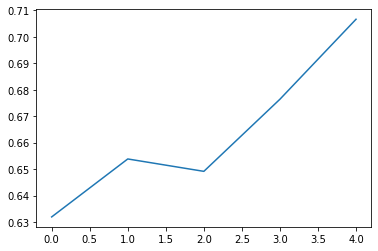

NDCG: 0.33102327953678035
NDCGMAE: [0.002686042307359719, 0.0012589879686443226, 0.0007300590903430083, 0.005432705900911043, 0.0019413039818012808]


C:\Users\Tom Leung\OneDrive\文件\武汉大学\硕士投稿\主题热度预测\program\utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))


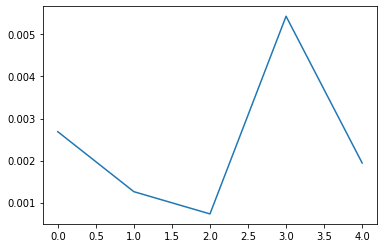

In [15]:
metrics = ['mae', 'ndcg']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred.reshape(5141, -1), scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}MAE:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [17]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         1.0       0.88      0.88      0.88     17990
         2.0       0.43      0.43      0.43      3855
         3.0       0.35      0.35      0.35      2570
         4.0       0.42      0.42      0.42      1290

    accuracy                           0.74     25705
   macro avg       0.52      0.52      0.52     25705
weighted avg       0.74      0.74      0.74     25705

